# Generating synthetic time series from ENTSO-E data

Import `time_series` module:

In [1]:
import sys
sys.path.append('..')

import time_series as ts

Other dependencies:

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Download ENTSO-E data

In [3]:
data_source = os.path.expanduser('~/data/entso-e/raw') # choose the path to your data folder here


- Go to the source directory chosen above

- Connect to ENTSO-E transparency database with secure FTP:

```console
sftp <email>@sftp-transparency.entsoe.eu
```

- Enter your password
- Parse the data, e.g. the total load for the year 2023 (12 files):

```console
ls /TP_export/ActualTotalLoad_6.1.A/2023*
```

- Download the data

```console
get /TP_export/ActualTotalLoad_6.1.A/2023*
```

- Close the FTP connection 

```console
exit
```

## Extract time series from raw ENTSO-E data

Method to extract time series from ENTSO-E raw data files:

Frequency format:
- 'H': one hour
- '2H': two hours
- '30T': 30 minutes
- '15T': 15 minutes

In [4]:
entsoe_types = {
    'load': 'ActualTotalLoad_6.1.A'
}

In [5]:
def extract_entsoe_time_series(type: str, country_code: str, year: int, frequency: str = 'H'):
    if type in entsoe_types.keys():
        type = entsoe_types[type]
    timesteps = [str(t) for t in pd.date_range('%s-01-01' % year, '%s-01-01' % (year + 1), freq=frequency, inclusive='left')]
    time_series_dict = {t: None for t in timesteps}
    for month in range(1, 13):
        data = pd.read_csv('%s/%d_%02d_%s.csv' % (data_source, year, month, type), sep='\t')
        country_data = data[(data.MapCode==country_code) & (data.AreaTypeCode=='CTY')]
        monthly_dict = dict(zip(country_data['DateTime'].apply(lambda x: x[:19]), country_data['TotalLoadValue']))
        time_series_dict.update(monthly_dict)
    
    return [time_series_dict[t] for t in timesteps]

Example: total load for Switzerland in 2023, with hourly time steps (default)

In [6]:
load_CH_2023 = extract_entsoe_time_series('load', 'CH', 2023)

In [7]:
len(load_CH_2023) == 365 * 24

True

Example: total load for Germany in 2016, with 15-minute time steps

In [8]:
load_DE_2016 = extract_entsoe_time_series('load', 'DE', 2016, '15T')

In [9]:
len(load_DE_2016) == 366 * 24 * 4

True

Some values can be missing. They can be fixed by interpolation, using:

In [10]:
load_CH_2023 = ts.interpolate_missing_values(load_CH_2023)

Interpolating 1 missing values spread over 1 gap(s)


In [11]:
load_DE_2016 = ts.interpolate_missing_values(load_DE_2016)

Interpolating 0 missing values spread over 0 gap(s)


## Prepare periodic series

Turn the data into periodic series starting on the first Monday in January:

In [12]:
load_CH_2023_periodic = ts.make_364_periodic(load_CH_2023, 2023)

Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 1 days to make it start on a Monday


**Remark**: if the year is not specified, the function determines by itself the position of the first Monday using the periodicity properties of the time series (Saturdays and Sundays have different profiles than weekdays):

In [13]:
load_DE_2016_periodic = ts.make_364_periodic(load_DE_2016)

Cropping leap year (366 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 3 days to make it start on a Monday


Plot a winter and a sommer week:

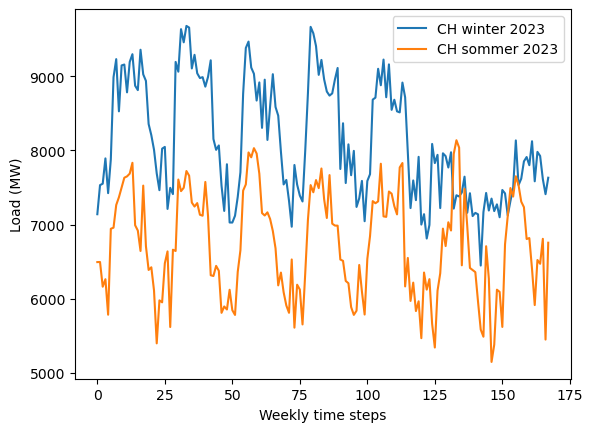

In [14]:
plt.plot(load_CH_2023_periodic[7*24:2*7*24], label='CH winter 2023')
plt.plot(load_CH_2023_periodic[26*7*24:27*7*24], label='CH sommer 2023')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

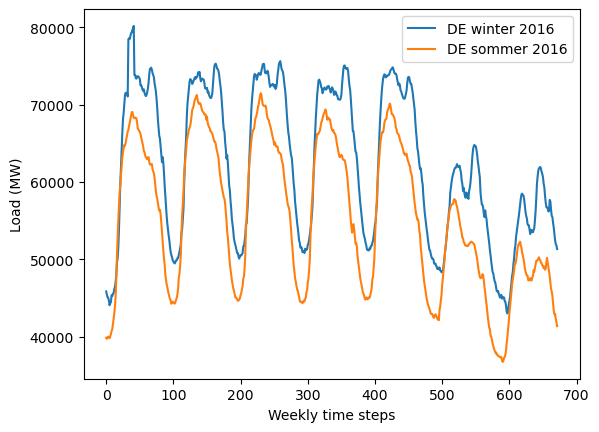

In [15]:
plt.plot(load_DE_2016_periodic[7*24*4:2*7*24*4], label='DE winter 2016')
plt.plot(load_DE_2016_periodic[26*7*24*4:27*7*24*4], label='DE sommer 2016')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

Weekly average over a year:

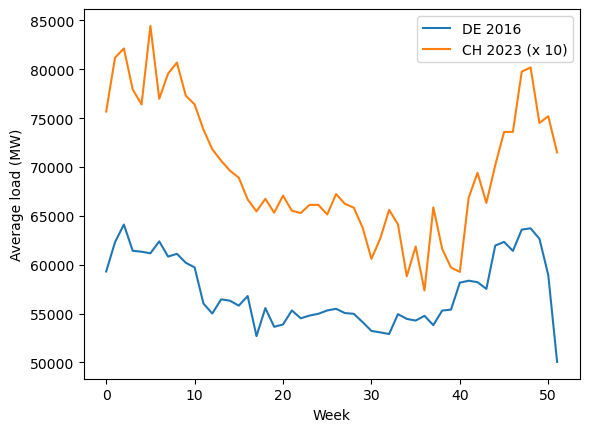

In [16]:
plt.plot(load_DE_2016_periodic.reshape(52, -1).mean(axis=1), label='DE 2016')
plt.plot(10 * load_CH_2023_periodic.reshape(52, -1).mean(axis=1), label='CH 2023 (x 10)')
plt.xlabel('Week')
plt.ylabel('Average load (MW)')
plt.legend()
plt.show()

## Create a statistical model

In [17]:
load_CH_2015_2023 = [ts.interpolate_missing_values(extract_entsoe_time_series('load', 'CH', year))
                     for year in range(2015, 2024)]

Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 0 missing values spread over 0 gap(s)
Interpolating 1 missing values spread over 1 gap(s)


In [25]:
load_CH_2015_2023_periodic = np.array([ts.make_364_periodic(time_series, verbose=False)
                                       for time_series in load_CH_2015_2023])

In [31]:
load_CH_avg_periodic = load_CH_2015_2023_periodic.mean(axis = 0)

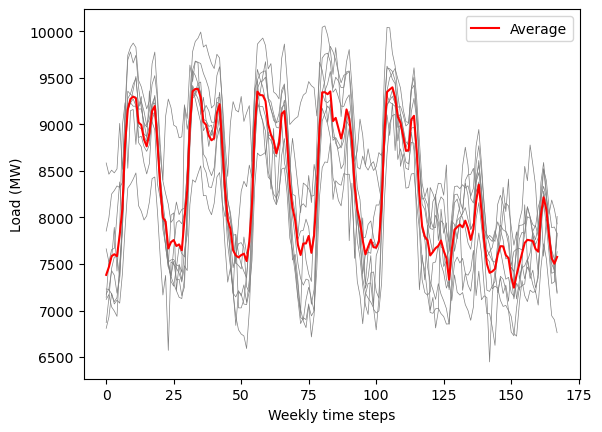

In [42]:
plt.plot(load_CH_2015_2023_periodic[:, 7*24:2*7*24].transpose(), color='gray', linewidth=0.5)
plt.plot(load_CH_avg_periodic[7*24:2*7*24], label='Average', color='red')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()